# Fire Watch

## Exploring K-means algorithm in order to find high risk areas and optimal fire station locations in Opole Voivodeship, Poland.

<img src="https://i.postimg.cc/BnqQ5NdL/fire.jpg">

### Table of contents:
1. Introduction
2. Goals
3. Data scraping and cleaning  
   3.1. Fire Watch algotithm  
   3.2. Data preparation  
4. Interventions  
   4.1. Region characteristics  
   4.2. Geolocating events  
   4.3. Interventions - map  
5. High risk areas  
   5.1. Opole Voivodeship fire stations  
   5.2. Finding central points - K-means algorithm  
   5.3. High risk areas - map  
6. Optimal fire station locations
7. Summary

## 1. Introduction

It's **20 February 2020**. When I write this words massive storms and winds are hurling through Europe, leaving severe damages and casualities. In just one evening my Fire Watch algorithm registered 507 interventions in my region. This day strengthened my conviction, that this is very important issue, that should never be underestimated.

I'm talking about Fire Departement and it's importance in our daily lives.

Ever since i moved from the city to the suburbs, besides enjoying peace and closeness to nature I also experienced the dangers behind it. Wildfires spreading through fields in a dry and hot summers, trees falling under the pressure of the winds, flooding from massive rains. Living in a cosy flat in a city made all of those problems seem distant. Now they are much more tangable.

I came up with the idea of Fire Watch project while checking our local Fire Departement site on which you could monitor  all interventions in a real time. I was wondering if there are any reguralities at all in intervention locations or if there is a way to optimalise reaction time from local fire stations. As the project evolved I added different analytic ideas, which ultimately contributed to the final version of the Fire Watch project.

In this project I explored such areas as:
- data scraping from html sites
- gathering geolocations thorugh api tool
- converting response to json format and extracting data
- machine learning basics - exploring K-means algorithm possibilities
- geolocation data analysis and interpretation

Time period in which I gathered data to this project:

**7.02.2022 - 20.02.2022**

## 2. Goals

**1. Gather Data**  
The basis. I needed to create an algotithm, that will scrape all of the current interventions in specified time intervals. The more data, the better analysis and more accurate optimalisation.

**2. Define area**  
In order to place gathered data in a space, I needed to define and plot the area that we will be analysing - which is Opole Voivodeship in Poland (where I live). The goal was to find and scrape shape data, as well as some major cities to put them on a plotted map.

**3. Geolocate interventions** 
Using geoapifi tool I managed to find coordinates of data gathered by Fire Watch algorithm. Next to algorithm alone, this was the second biggest (and most important) part of a code, which needed pricise query and verification in order to get the most reliable information.

**4. Visualise interventions** 
After regional data and interventions data were gathered, the only thing left was to plot them all on a map, highlighting interventions type and size (definded by number of units sent).

**5. Define central points ov events**  
Using K-means algorithm I found the optimal number of clusters in which interventions can be grouped, and visualised their central points (centroids). This will tell us about high risk areas in the region. On top of that information I decided to place locations of Opole Voivodeship fire stations, to see how they correspond to those crucial areas (data scraped from wikipedia and located by geoapify tool).

**6. Find optimal fire station locations**  
Using K-means algorithm I defined the number of central points as number of Opole Voivodeship fire stations, to find optimal locations (in terms of distance from registered interventions). Using reverse geolocation I found location names of calculated points. Finally, I designed an algorithm calculating distance from optimal fire station locations to actual fire stations locations, to filter those points, that already have fire stations nearby (in defined ranges in kilometers)

## 3. Data scraping and cleaning

### 3.1. Fire Watch algorithm

The algorithm that I created evolved through time. First it was simple loop that scraped data from <a href="https://psp.opole.pl/prowadzone-interwencje-psp-i-osp-woj-opolskiego/?fbclid=IwAR1y7FJgyRi7saVtJKDfX_7b53v4AB2Qngj9lyq_2_nh7Qb35-aHTD9Hl6s">Opole Voivodeship Fire Department intervention monitor</a> and wrote it into csv file. I activated the loop manually from time to time. Soon enough I realised It can be improved by including automated time intervals in an endless loop ( time.wait() method ). After that I also added notifications and created log file, to register all data extracts. The final version of Fire Watch algorithm looked like this:

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time

importLog = pd.read_csv('./ImportLog.csv', index_col=0)
loop = 0
while True:
    loop += 1
    try:
        fireWatch = pd.read_csv('./FireWatchInfo.csv', index_col=0).fillna('')
        #scraping new data as new dataframe
        page = requests.get('https://psp.opole.pl/prowadzone-interwencje-psp-i-osp-woj-opolskiego/?fbclid=IwAR1y7FJgyRi7saVtJKDfX_7b53v4AB2Qngj9lyq_2_nh7Qb35-aHTD9Hl6s')
        soup = BeautifulSoup(page.content, 'html.parser')
        data = []
        for i in soup.find(attrs={'id': 'tablepress-5'}).find_all('tr')[1:]:
            row = []
            for j in i.find_all('td'):
                row.append(j.get_text())
            data.append(row)
        newData = pd.DataFrame(columns=fireWatch.columns.tolist(), data=data)
        #adding new data to existing dataframe
        fireWatch = fireWatch.append(newData)
        #basic data cleaning
        fireWatch['NumberOfUnits'] = fireWatch['NumberOfUnits'].astype(int)
        fireWatch['Street'] = fireWatch['Street'].apply(lambda x: x.replace('ul. ','').strip())
        fireWatch = fireWatch.drop_duplicates(subset=None, keep='first').reset_index(drop=True)
        fireWatch.to_csv('FireWatchInfo.csv')
        #updating import log
        importLog.loc[-1]=[time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), len(fireWatch.index)]
        importLog = importLog.reset_index(drop=True)
        importLog.to_csv('ImportLog.csv')
        print('Date: {}, Time: {}, loop number: {}, number of interventions: {}'.format(time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), loop,len(fireWatch.index)))
        time.sleep(1800)
    #including exception in case of loop failure - eg. losing internet connection
    except:
        importLog.loc[-1]=[time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), 'error']
        importLog = importLog.reset_index(drop=True)
        importLog.to_csv('ImportLog.csv')
        print('Date: {}, Time: {}, loop number: {}, error'.format(time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), loop))
        time.sleep(900)

This code operated independently in a separate jupyter notebook file, while I was reading and analysing data in this one. The goal was to extract new data, save them in a dataframe, update existing dataframy by new data, conduct basic cleaning (transform numerical data to int values, get rid of redundant string elements, drop duplicated rows, reset index). I also designed an exception in case something went wrong, so the loop could still continue without breaking. The algorithm worked perfectly.

Without further ado let us dive into core data analysis.

### 3.2. Data preparation

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib.offsetbox import AnchoredText

In [3]:
fireWatch = pd.read_csv('./FireWatchInfo.csv', index_col=0).fillna('')
fireWatch.tail()

,Date,Type,District,Town,Street,Description,NumberOfUnits
1153,20-02-2022 11:43,Miejscowe zagrożenie,nyski,Nysa,Otmuchowska,Droga - plama oleju,2
1154,20-02-2022 12:19,Miejscowe zagrożenie,nyski,Otmuchów,,Droga rowerowa - drzewo,1
1155,20-02-2022 12:35,Miejscowe zagrożenie,brzeski,Borkowice,,Drzewo,3
1156,20-02-2022 12:52,Miejscowe zagrożenie,prudnicki,Lubrza,Nowej Naprawy,Poderwana blacha dachu,1
1157,20-02-2022 12:45,Pożar,nyski,Ogonów,,Pole uprawne - ściernisko,3


As you can see, so far I managed to gather information about 1157 interventions. There is a catch however. During basic cleaning in Fire Watch algorithm I was able to get rid of duplicated rows - but only considering all data (all columns). Inspecting the data I gathered I noticed that there is a certain way those informations are placed on Fire Department site. First there is usually basic info from registration - when? where? what? The information about the incident is often updated though. For example we knew the city, but now we update street address. We thought it was car collision (in event desciption) but after arriving it turned out to be truck instead. We sent 2 units, but situation was so severe, that we needed to send 3 more.

Basically - the data was updated. The only core elements that didn't change were - **Date** (accuracy down to the minute assured that it was highly unlikely to have two events at the exact same time and at the exact same place), **District** and **Town**. First thing that we have to do then is to remove all duplicates based on those columns, and leave only **last one** - the most updated data.

Since I also noticed some irrelevant info hidden in brackets I decided to clean location strings from them - this will make geolocating much more accurate.

In [4]:
fireWatch['Town'] = fireWatch['Town'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
fireWatch['Street'] = fireWatch['Street'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
fireWatch = fireWatch.drop_duplicates(subset=['Date','District','Town'],keep='last').reset_index(drop=True)
len(fireWatch.index)

922

This is the final number of gathered interventions in Opole Voivodeship.

## 4. Interventions

### 4.1. Region characteristics

In [7]:
import matplotlib.pyplot as plt
import json
from requests.structures import CaseInsensitiveDict
from statistics import mean
import time

To place interventions on a map I need to design the map itself.

We will start by defining boundaries of Opole Voivodeship. On <a href="http://download.geofabrik.de/europe/poland/opolskie.html">Geofabrik project site</a> I found different kinds of data about my region - including .poly file that describes the extent of this region. We will use those coordinates to map them later on. 

In [8]:
#scraping shape data of Opole Voivodeship
opolskiePoly = requests.get('https://download.geofabrik.de/europe/poland/opolskie.poly')
opolskieCoord = []
for i in opolskiePoly.text.split('\n')[2:-3]:
    opolskieCoord.append(i.strip().split('   '))
opolskieShape = pd.DataFrame(data=opolskieCoord, columns=['longitude','latitude']).astype(float)

The map itself will be a bit empty. To mark some key locations, we will add data about 10 biggest cities in Opole Voivodeship. This data can be found on <a href="https://pl.wikipedia.org/wiki/Wojew%C3%B3dztwo_opolskie">polish wikipedia site</a>. Let's gather info about city name and population.

In [9]:
#scraping data about 10 biggest cities in opolskie voidenship
cityUrl = requests.get('https://pl.wikipedia.org/wiki/Wojew%C3%B3dztwo_opolskie')
citySoup = BeautifulSoup(cityUrl.content, 'html.parser')
cityList = []
for i in citySoup.find_all(attrs={'class':'wikitable sortable'})[1].find_all('tr')[1:11]:
    cityList.append([i.find_all('td')[2].get_text(), i.find_all('td')[4].get_text()])
biggestCities = pd.DataFrame(data=cityList, columns=['Name','Population'])
biggestCities

,Name,Population
0,Opole,128 012
1,Kędzierzyn-Koźle,60 383
2,Nysa,43 580
3,Brzeg,35 491
4,Kluczbork,23 396
5,Prudnik,20 887
6,Strzelce Opolskie,17 766
7,Namysłów,16 650
8,Krapkowice,16 105
9,Głuchołazy,13 435


As I mentioned in the introduction, in this project I expanded my knowledge by possibilities that give geolocating api tools. And I was honestly amazed how great and simple tool it is. Here I used <a href="https://www.geoapify.com/">Geoapify</a> tool. This allowed my to extract data about coordinates using information about location (city, state, country).

In [10]:
#getting cities coordinates via goapify geolocating tool
cityCoordinates = []
for name in biggestCities['Name']:
    url = "https://api.geoapify.com/v1/geocode/search?city="+name+"&state=Opole%20Voivodeship&country=Poland&apiKey=f4f828156a78469f8c838fe180fcc8ad"
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    resp = requests.get(url, headers=headers)
    resp_dict = json.loads(resp.content)
    longitude = []
    latitude = []
    for i in resp_dict['features']:
        longitude.append(i['properties']['lon'])
        latitude.append(i['properties']['lat'])
    cityCoordinates.append([mean(longitude), mean(latitude)])
coordinates = pd.DataFrame(data=cityCoordinates, columns=['longitude','latitude'])
biggestCities = pd.concat([biggestCities,coordinates], axis=1)
biggestCities

,Name,Population,longitude,latitude
0,Opole,128 012,17.923641,50.666818
1,Kędzierzyn-Koźle,60 383,18.206216,50.344962
2,Nysa,43 580,17.337213,50.475726
3,Brzeg,35 491,17.468527,50.858020
4,Kluczbork,23 396,18.205496,50.971729
5,Prudnik,20 887,17.578472,50.321212
6,Strzelce Opolskie,17 766,18.303377,50.513852
7,Namysłów,16 650,17.717791,51.075508
8,Krapkowice,16 105,17.971216,50.481665
9,Głuchołazy,13 435,17.383381,50.317083


This is all we need to place those cities on our Opole Voivodeship map.

Now we can do the same with Fire Department emmergnecy events.

### 4.2. Geolocating events

This time the code will be a bit more advanced. The location data we have is not that precise as was in the previous case (10 biggest, most important cities in the region). Here we need to consider multiple paths and possibilities. We don't know how Geoapify will react to less accurate data. We will design a few key steps for this algorithm to work:

- if there is **street** and **town** data, search by both. If not - search by only **town** data.
- gather all longitude and latitude data from json response and calculate mean (there is a possibility of finding several points on a map, especially considering a street data).
- reverse geolocate calculated mean longitude and latitude and check if the point is in the Opole Voivodeship
- if it is - append calculated coordinates to the final coordinates list
- if it is not in Opole Voivodeship boundaries - remove data about **street** and try again (if we can't find exact loaction, the town itself will be sufficient)
- if the point is still not in the Opole Voivodeship boundaries, append NaN values to the final coordinates list

In [11]:
coordinates = []
start_time = time.time()
for i,j in zip(fireWatch['Street'], fireWatch['Town']):
    condition = 1
    while condition > 0:
        if len(i)>1:
            url = "https://api.geoapify.com/v1/geocode/search?street="+i+"&city="+j+"&state=Opole%20Voivodeship&country=Poland&apiKey=f4f828156a78469f8c838fe180fcc8ad"
        else:
            url = "https://api.geoapify.com/v1/geocode/search?city="+j+"&state=Opole%20Voivodeship&country=Poland&apiKey=f4f828156a78469f8c838fe180fcc8ad"
        resp = requests.get(url, headers=headers)
        resp_dict = json.loads(resp.content)
        longitude = []
        latitude = []
        for i in resp_dict['features']:
            longitude.append(i['properties']['lon'])
            latitude.append(i['properties']['lat'])
        #reverse geolocation - checking if coordinates are in Opole Voivodeship
        url2 = "https://api.geoapify.com/v1/geocode/reverse?lat="+str(mean(latitude))+"&lon="+str(mean(longitude))+"&apiKey=293684a6df2f4f46afaa2ea945a87541"
        resp2 = requests.get(url2, headers=headers)
        resp_dict2 = json.loads(resp2.content)
        state = resp_dict2['features'][0]['properties']['state']
        #if coordinates are within Opole Voivodeship boundaries, data is valid
        if 'opol' in state.lower():
            coordinates.append([mean(longitude), mean(latitude)])
            condition = 0
        #if not - try the loop again without street address. If still not - append NaN values
        else:
            if condition == 2:
                coordinates.append([np.nan, np.nan])
                condition = 0
            else:
                i=''
                condition = 2

fireWatchCoordinates = pd.DataFrame(data=coordinates, columns=['longitude','latitude'])
fireWatchData = pd.concat([fireWatch,fireWatchCoordinates], axis=1)
nanvals = len(fireWatchData[fireWatchData['longitude'].isna()].index)
print('''Coordinates uploaded!
It took {} minutes to collect all requested data.
Number of rows with NaN coordinates: {}'''.format(round((time.time()-start_time)/60,1),nanvals))

Coordinates uploaded!
It took 14.2 minutes to collect all requested data.
Number of rows with NaN coordinates: 1


Only 1 row without coordinates. Good result. Let's check it.

In [12]:
fireWatchData[fireWatchData['longitude'].isna()]

,Date,Type,District,Town,Street,Description,NumberOfUnits,longitude,latitude
184,14-02-2022 15:03,Miejscowe zagrożenie,nyski,Podlesie,,Droga - drzewo,2,NaN,NaN


I have no idea why the algorithm was not able to lacte Podlasie town, but it's not important right now. We have enough data to analyse. Let's drop this one and proceed to visualisation.

In [13]:
fireWatchData.dropna(inplace=True)

### 4.3. Interventions - map

As we examined earlier, the intervention data set consist of several different types of information. The main ones that we will use to distinguish our points will be **Type** and **NumberOfUnits**. There are two types of interventions:  
- Fires ("Pożar" in polish)
- Local threat ("Miejscowe zagrożenie" in polish)
The number of units sent to the intevention site will determine the size of the point (the bigger bubble, the more fire trucks sent to help), making this map a bubble chart in a way.

And of course we will include regional data gathered in the previous steps of the project.

Here is the outcome:

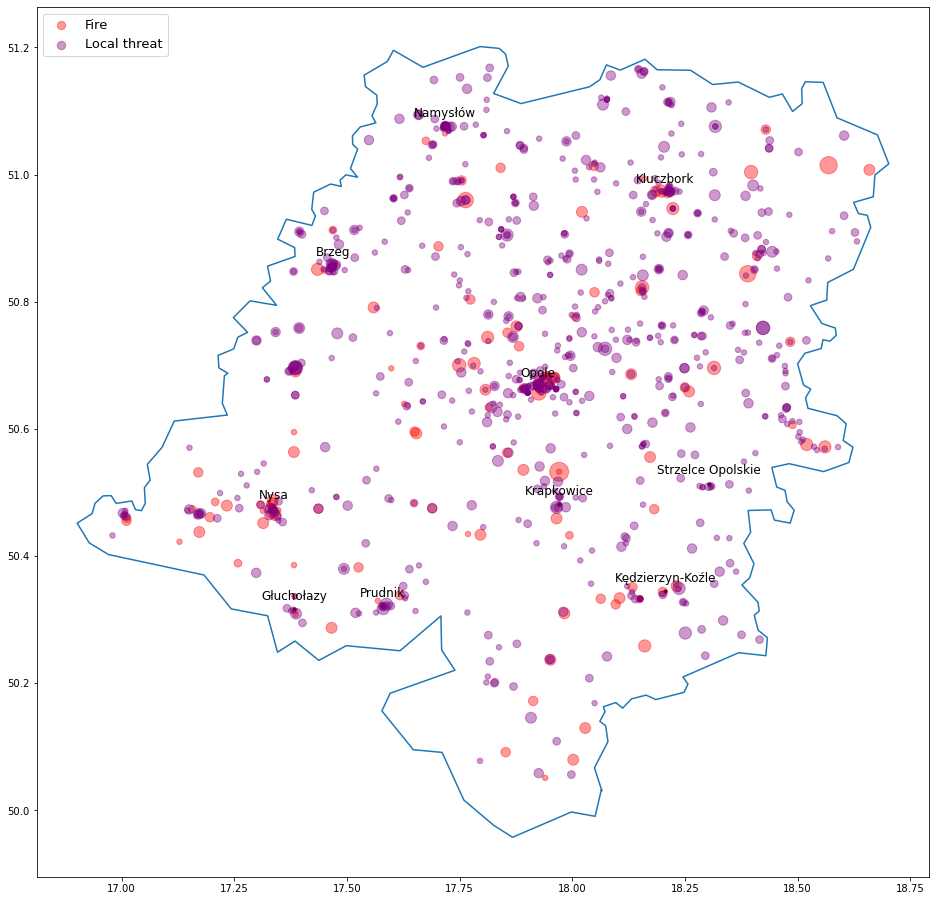

In [14]:
localThreat = fireWatchData[fireWatchData['Type']=='Miejscowe zagrożenie']
fire = fireWatchData[fireWatchData['Type']=='Pożar']

plt.figure(figsize=(16,16))
plt.plot(opolskieShape['longitude'], opolskieShape['latitude'])
plt.scatter(biggestCities['longitude'], biggestCities['latitude'],c='black', s=10)
plt.scatter(fire['longitude'], fire['latitude'], c='red', s=fire['NumberOfUnits']*30, alpha=0.4, label='Fire')
plt.scatter(localThreat['longitude'], localThreat['latitude'], c='purple', s=localThreat['NumberOfUnits']*30, alpha=0.4, label='Local threat')
legend = plt.legend(loc="upper left", fontsize=13)
for handle in legend.legendHandles:
    handle.set_sizes([70])
for i, txt in enumerate(biggestCities['Name']):
    plt.annotate(txt, (biggestCities['longitude'][i], biggestCities['latitude'][i]+0.01), ha='center', va='bottom', size=12)

plt.show()

As interesting as it seems, the data can be not that clear to analyse because of the overlapping. Let's plot two more maps, dividing poitns by the type itself:

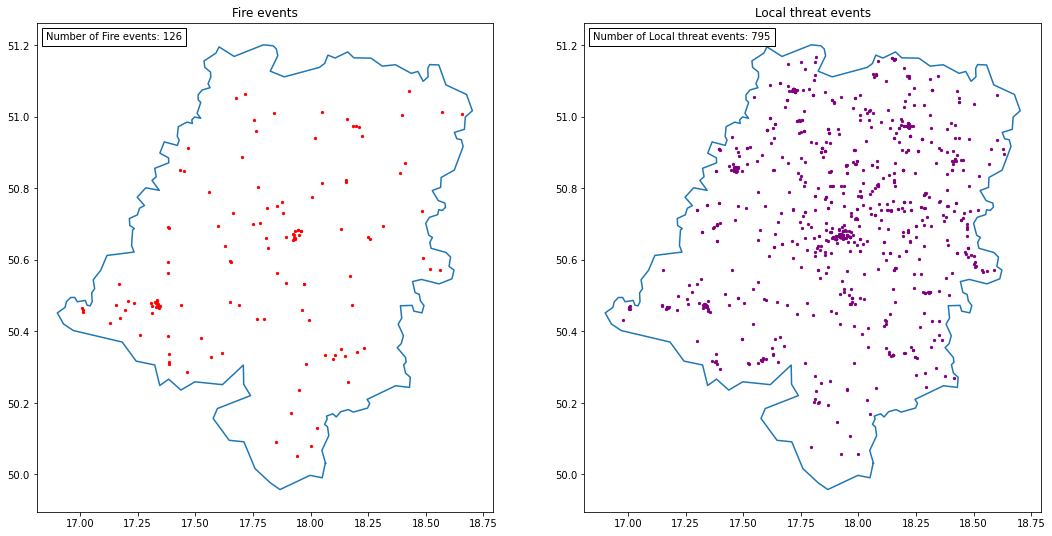

In [15]:
fig, axs = plt.subplots(2, figsize=(18,9))

axs[0] = plt.subplot(1,2,1)
axs[0].plot(opolskieShape['longitude'], opolskieShape['latitude'])
axs[0].scatter(fire['longitude'], fire['latitude'], c='red', s=5, label='Fire')
axs[0].add_artist(AnchoredText('Number of Fire events: {}'.format(len(fire.index)),loc=2, prop=dict(size=10)))
plt.title('Fire events')

axs[1] = plt.subplot(1,2,2)
axs[1].plot(opolskieShape['longitude'], opolskieShape['latitude'])
axs[1].scatter(localThreat['longitude'], localThreat['latitude'], c='purple', s=5, label='Local threat')
axs[1].add_artist(AnchoredText('Number of Local threat events: {}'.format(len(localThreat.index)),loc=2, prop=dict(size=10)))
plt.title('Local threat events')

plt.show()

This is much more clearer. We already can notice some clusters on those maps.

We will need to properly distinguish them though. This is where Machine Learning area comes in.

## 5. High risk areas

### 5.1. Opole Voivodeship Firestations

Before we jump into Machine Learning basics, we will gather information about **fire stations in Opole Voivodeship**.

On the <a href="https://fireon.pl/jednostki/osp/wojewodztwo/opolskie">Fireon</a> site we can find information about all fire station units in the region. There are divided into State Fire Department ("Państwowa Straż Pożarna" in polish) and Volunteer Fire Department ("Ochotnicza Straż Pożarna" in polish). We will follow exact same steps as we did before - scrape data from site into dataframe, clean data (here also including grouping data by the city) and geolocate points.

In [16]:
#Volunteer Fire Departmen
VFD = []
#State Fire Department
SFD = []
for i in range(1,8):
    url = 'https://fireon.pl/jednostki/osp/wojewodztwo/opolskie/8?p='+str(i)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    for j in soup.find_all('h6'):
        VFD.append(j.get_text())
        
for i in range (1,3):
    url = 'https://fireon.pl/jednostki/psp/wojewodztwo/opolskie/8?p='+str(i)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    for j in soup.find_all('h6'):
        SFD.append(j.get_text())
        
FD = pd.Series(data=VFD + SFD)

In [17]:
#defining cleaning function that will strip strings of irrelevant data, leaving only city name
def clear(col):
    stripList = '1 2 3 4 5 6 7 8 9 0'.split() + ['OSP', 'PSP', 'JRG']
    for i in stripList:
        col = col.split(i)[-1]
    return col.strip()

In [18]:
FD = FD.apply(clear)
FD_DF = pd.DataFrame(data=FD.value_counts()).reset_index()
FD_DF.columns=['City','NumberOfStations']
FD_DF

,City,NumberOfStations
0,Opole,4
1,Gierałcice,3
2,Kędzierzyn-Koźle,3
3,Lipki,3
4,Olszanka,2
...,...,...
144,Niwnica,1
145,Łąka,1
146,Jasienie,1
147,Wójcice,1


We have the list of all cities that have fire stations units. Let's geolocate them.

In [19]:
#getting cities coordinates via goapify geolocating tool
FDcoords = []
for name in FD_DF['City']:
    url = "https://api.geoapify.com/v1/geocode/search?city="+name+"&state=Opole%20Voivodeship&country=Poland&apiKey=f4f828156a78469f8c838fe180fcc8ad"
    resp = requests.get(url, headers=headers)
    resp_dict = json.loads(resp.content)
    longitude = []
    latitude = []
    for i in resp_dict['features']:
        longitude.append(i['properties']['lon'])
        latitude.append(i['properties']['lat'])
    FDcoords.append([mean(longitude), mean(latitude)])
coordinates = pd.DataFrame(data=FDcoords, columns=['longitude','latitude'])
firestations = pd.concat([FD_DF,coordinates], axis=1)
firestations.head()

,City,NumberOfStations,longitude,latitude
0,Opole,4,17.923641,50.666818
1,Gierałcice,3,17.813614,50.779928
2,Kędzierzyn-Koźle,3,18.206216,50.344962
3,Lipki,3,17.394482,50.910207
4,Olszanka,2,17.723205,50.698520


Perfect! Now we can jump into Machine Learning part.

### 5.2. Finding central points - K-means algorithm

In order to conduct this analysis I decided to use **K-means algorithm**, which is perfect for grouping positional and spatial data. It will help us determine the optimal number of groups (clusters) and their central points (centroids). They will present the central points of high risk areas in Opole Voivodeship.

In [20]:
from sklearn.cluster import KMeans

We will start with conducting the **Elbow Method**. By applying determined range of the number of clusters, we will check how the algorithm corresponds to them by calulating WCSS ( Within-Cluster Sum of Square ).

In [31]:
fwCoords = fireWatchData[['longitude','latitude']]

WCSS = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fwCoords)
    WCSS.append(kmeans.inertia_)

C:\Users\wasal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


On the plotted chart (that looks like an elbow) we need to find the place when it rapidly changes shape (to the more parallel to the x-axis) - the elbow "flexion". This will be the optimal amount of clusters to apply in the algorithm.

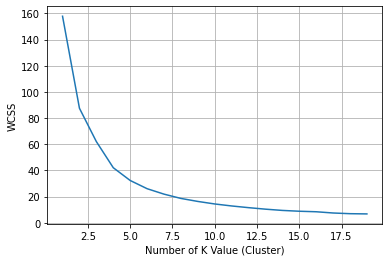

In [32]:
plt.plot(range(1,20),WCSS)
plt.xlabel('Number of K Value (Cluster)')
plt.ylabel('WCSS')
plt.grid()
plt.show()

It's not that obvious to determine the optimal number of clusters here, but I will go with **5**.

Up to 5 clusters, the drop is sudden - afterwards it slows significantly.

### 5.3. High risk areas - map

Now that we have optimal number of clusters we can plot them on a map, highliting the central points of high tisk areas in Opole Voivodeship. We will also plot the locations of fire stations to see where they are in relation to event centroids locations.

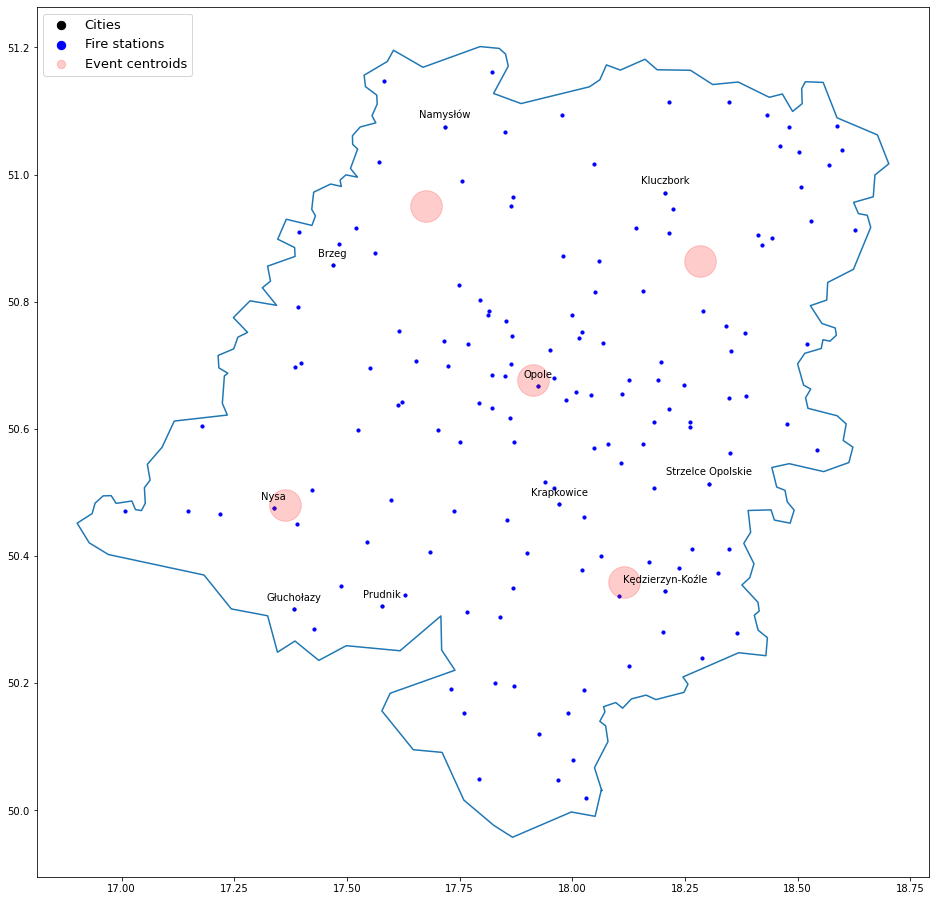

In [33]:
kmeans = KMeans(n_clusters=5, max_iter=300, random_state=1)
clusters = kmeans.fit_predict(fwCoords)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize=(16,16))
plt.plot(opolskieShape['longitude'], opolskieShape['latitude'])
plt.scatter(biggestCities['longitude'], biggestCities['latitude'],c='black', s=7, label='Cities')
plt.scatter(firestations['longitude'], firestations['latitude'], c='blue', s=10, label='Fire stations')
plt.scatter(x=centroids[:,0], y=centroids[:,1], c='red', s=1000, alpha=0.2, label='Event centroids')

legend = plt.legend(loc="upper left", fontsize=13)
for handle in legend.legendHandles:
    handle.set_sizes([70])

for i, txt in enumerate(biggestCities['Name']):
    plt.annotate(txt, (biggestCities['longitude'][i], biggestCities['latitude'][i]+0.01), ha='center', va='bottom', size=10)
plt.show()

That's it. As we can see, not every centroid location is properly covered - especially the one between **Brzeg** and **Namysłów**. There are not that many fire stations in the area comparing to others.

So where it would be best to place them? Where the fire stations in Opole Voivodeship should be located?

## 6. Optimal fire stations locations

In [44]:
from adjustText import adjust_text
import matplotlib.gridspec as gridspec
from math import sqrt

To find optimal fire station locations we will also use K-means algorithm. The number of clusters however will be not optimal. It will be determined by number of fire stations in the region:

In [36]:
len(firestations.index)

149

Let's plot two maps - first will show us again where fire stations are present. Second - where they should be according to the algorithm. Where they should be considering distance to the gathered emergency data locations.

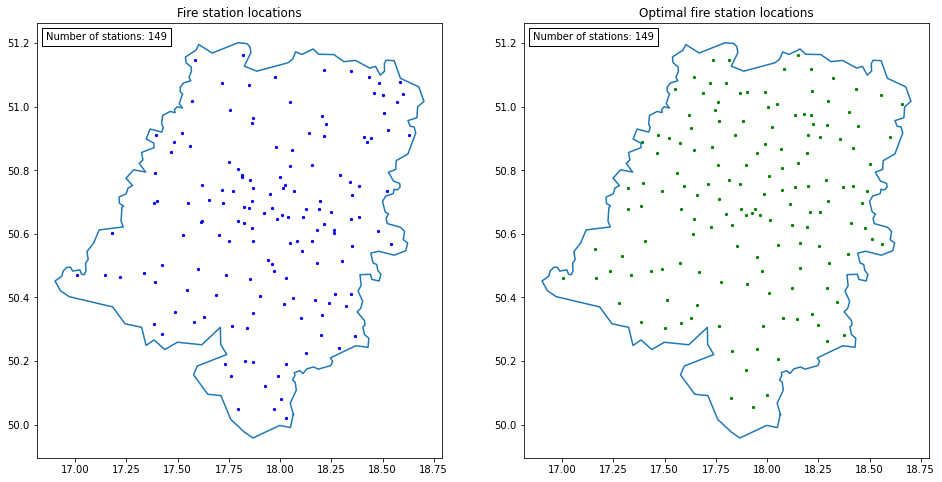

In [37]:
kmeans = KMeans(n_clusters=149, max_iter=300, random_state=1)
clusters = kmeans.fit_predict(fwCoords)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, axs = plt.subplots(2, figsize=(16,8))

axs[0] = plt.subplot(1,2,1)
axs[0].plot(opolskieShape['longitude'], opolskieShape['latitude'])
axs[0].scatter(firestations['longitude'], firestations['latitude'], c='blue', s=5, label='Fire station locations')
axs[0].add_artist(AnchoredText('Number of stations: {}'.format(len(firestations.index)),loc=2, prop=dict(size=10)))
plt.title('Fire station locations')

axs[1] = plt.subplot(1,2,2)
axs[1].plot(opolskieShape['longitude'], opolskieShape['latitude'])
axs[1].scatter(x=centroids[:,0], y=centroids[:,1], c='green', s=5, label='Ideal Fire station locations')
axs[1].add_artist(AnchoredText('Number of stations: {}'.format(len(centroids)),loc=2, prop=dict(size=10)))
plt.title('Optimal fire station locations')

plt.show()

From the first look we can see that optimal locations are more spread than acutal ones.

To conduct more precise analysis we will need to gather names of optimal locations, and then filter them on based on distance from existing firestations.

This will give us a list, where it would be best to build the fire station unit. Which areas will benefit from it the most.

First - reverse geolocating. Let's find out where the stations should be placed.

In [38]:
optLon = centroids[:,0]
optLat = centroids[:,1]
optData = []
for lon,lat in zip(optLon, optLat):
    url = "https://api.geoapify.com/v1/geocode/reverse?lat="+str(lat)+"&lon="+str(lon)+"&apiKey=f4f828156a78469f8c838fe180fcc8ad"
    resp = requests.get(url, headers=headers)
    resp_dict = json.loads(resp.content)
    optData.append([resp_dict['features'][0]['properties']['city'],
                     resp_dict['features'][0]['properties']['address_line1'],
                     resp_dict['features'][0]['properties']['address_line2'],
                     lon,
                     lat])

optList = pd.DataFrame(data=optData, columns=['City','AddressLine1', 'AddressLine2','longitude','latitude'])
optList.head()

,City,AddressLine1,AddressLine2,longitude,latitude
0,Kietrz,Polna 5,"Kietrz, Poland",17.998539,50.093530
1,Ozimek Obszar Wiejski,Poliwodzka 10,"46-043 Ozimek Obszar Wiejski, Poland",18.200444,50.750016
2,Wierzbnik,60a,"49-216 Wierzbnik, Poland",17.394005,50.758679
3,Opole,Ozimska 2,"45-057 Opole, Poland",17.925067,50.666609
4,Biskupów,Biskupów,"Nysa County, Poland",17.278466,50.381174


There is no reason for stations to be placed in a calculated location, if there is already a fire station nearby. This is why we will design a function, that will filter our dataframe from points with fire stations proximity, leaving only those more distant.

In order to do so we need to calculate distane between two points on a map. We need to use Pythagorean Theorem.

<img src="https://www.codingem.com/wp-content/uploads/2021/10/Screenshot-2021-10-17-at-21.50.25-1536x823.png" width=400>

- **C** is distance between two points.
- **A** is difference between x-axis values (longitude)
- **B** is difference between y-axis values (latitude)

The outcome of those calculations has to be multiplied by **111** to convert lat/lon format to kilometers.

If calculated distance is lesser than given distance, the row is dropped from the dataframe.

In [39]:
def check_area(df1, df2, area):
    newDF = df1
    for i in newDF.index:
        nlo = newDF.loc[i]['longitude']
        nla = newDF.loc[i]['latitude']
        for j in df2.index:
            flo = df2.loc[j]['longitude']
            fla = df2.loc[j]['latitude']
            dist = sqrt((nlo-flo)**2 + (nla-fla)**2)*111
            if dist < area:
                newDF = newDF.drop([i])
                break
    return newDF

Now when we have our function, we can apply it on the data sets and show filtered points on the map. For those calculations we will use 3 distance ranges: **5**, **10** and **15** kilometers.

In order to make our map more organized and visually clearer, I used <a href="https://github.com/Phlya/adjustText">Adjust Text</a> python library. If you are not familiar with it and you are also working with scatter points visualisation, I highly recommend it.

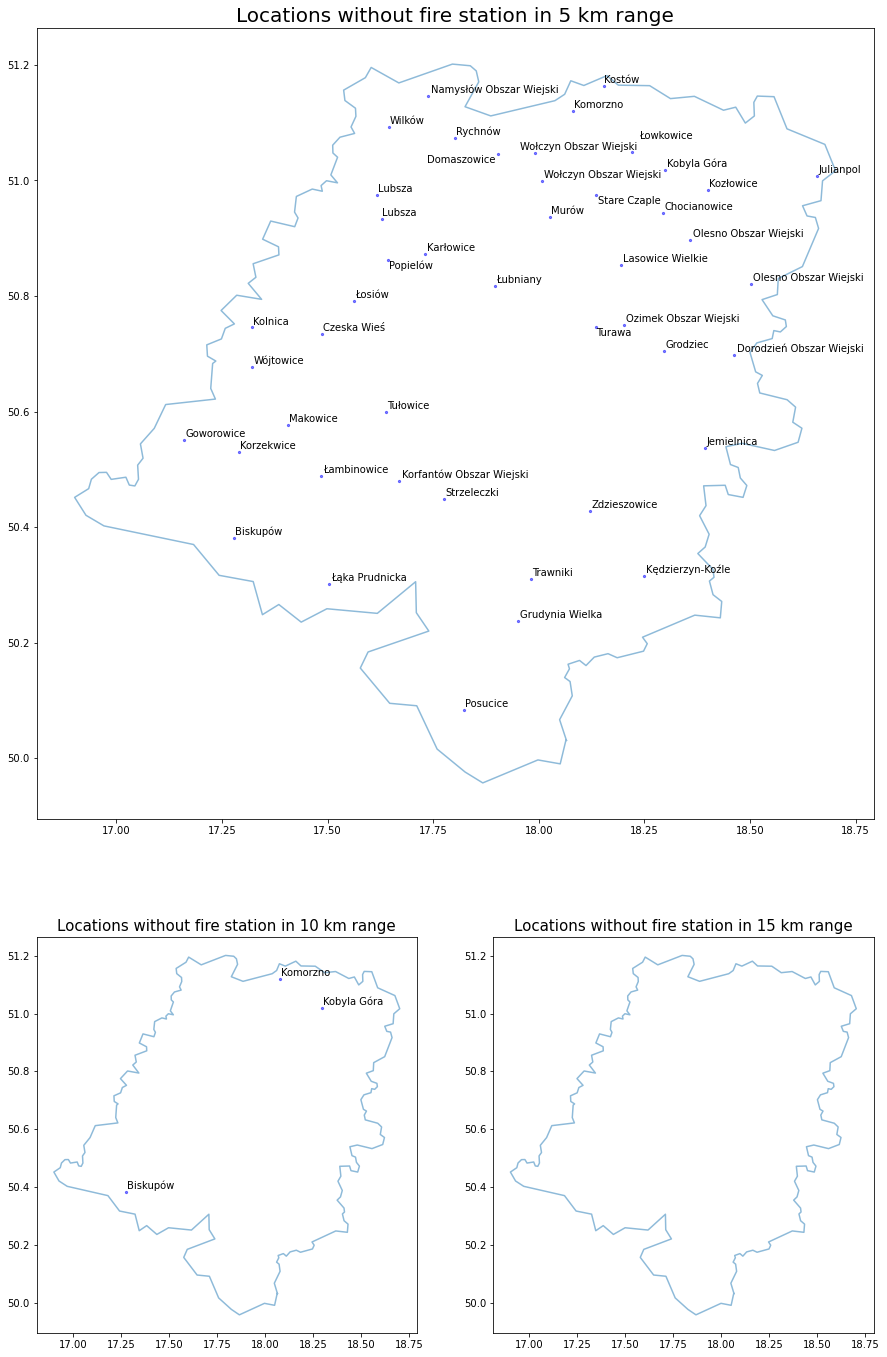

In [69]:
newStations5 = check_area(optList, firestations, 5)
newStations10 = check_area(optList, firestations, 10)
newStations15 = check_area(optList, firestations, 15)

plt.figure(figsize=(15,24))
plt.tight_layout()
gs = gridspec.GridSpec(2, 2, height_ratios=[2,1])

ax1 = plt.subplot(gs[0, :])
ax1.plot(opolskieShape['longitude'], opolskieShape['latitude'], alpha=0.5)
ax1.scatter(newStations5['longitude'], newStations5['latitude'], c='blue', s=5, alpha=0.5, label='Locations that will benefit from Fire Stations')
texts = []
for j, txt in enumerate(newStations5['City']):
    texts.append(plt.text(newStations5.iloc[j]['longitude'], newStations5.iloc[j]['latitude'], txt, size=10))
adjust_text(texts)
ax1.set_title('Locations without fire station in 5 km range', size=20)

ax2 = plt.subplot(gs[1, 0])
ax2.plot(opolskieShape['longitude'], opolskieShape['latitude'], alpha=0.5)
ax2.scatter(newStations10['longitude'], newStations10['latitude'], c='blue', s=5, alpha=0.5, label='Locations that will benefit from Fire Stations')
texts = []
for j, txt in enumerate(newStations10['City']):
    texts.append(plt.text(newStations10.iloc[j]['longitude'], newStations10.iloc[j]['latitude'], txt, size=10))
adjust_text(texts)
ax2.set_title('Locations without fire station in 10 km range', size=15)

ax3 = plt.subplot(gs[1, 1])
ax3.plot(opolskieShape['longitude'], opolskieShape['latitude'], alpha=0.5)
ax3.scatter(newStations15['longitude'], newStations15['latitude'], c='blue', s=5, alpha=0.5, label='Locations that will benefit from Fire Stations')
texts = []
for j, txt in enumerate(newStations15['City']):
    texts.append(plt.text(newStations15.iloc[j]['longitude'], newStations15.iloc[j]['latitude'], txt, size=8))
adjust_text(texts)
ax3.set_title('Locations without fire station in 15 km range', size=15)

plt.show()

As it turns out, fire stations in Opole Voivodeship are pretty well located. All of the calculated points have stations within 15 km range. If we narrow it down to 10 km range, the 3 points emerges. Those are locations, that would highly benefit from the presence of fire station, considering emergency events locations. Let's list those points:

In [70]:
check_area(optList, firestations, 10)

,City,AddressLine1,AddressLine2,longitude,latitude
4,Biskupów,Biskupów,"Nysa County, Poland",17.278466,50.381174
29,Komorzno,Miechowska 5,"46-250 Komorzno, Poland",18.080466,51.119928
50,Kobyla Góra,29,"46-310 Kobyla Góra, Poland",18.299290,51.018057


If Opole Voivodeship was planning to place 3 new fire stations, based on gathered data those would be the perfect spots for them.

## 7. Summary

Based on the information gathered in last weeks, we were able to find high risk areas and determine the perfect locations for fire stations in Opole Voivodeship.

The K-means algorithm turned out to be effective in terms of finding cluster groups and optimal locations to the emergency data collected with Fire Watch algorithm.

Unfortunately, the analysis conducted here is not perfect. As it usually is - the more data, the better calculations. If we would consider events from whole year for example, calculated high risk areas and optimal fire station locations points would differ. Who know what the algorithm would tell us then.

Maybe with the proper amount of data I will return to this topic to conduct much more detailed analysis.

I also have to say I really enjoy working with maps and positional data. I hope to expand my knowledge in that field even further in future projects.

Thanks for sticking by, and hope to see you again!